#### Análisis y Procesamiento de Señales

# Tarea Semanal Nº4
## *Primeras nociones de estimación espectral*

#### Alumnos: Augusto Colugnatti, Mateo Murgia
#### Profesor/es: Mariano Llamedo Soria , David Benoit, Hernan Ledesma


## Introducción teórica

A lo largo de esta tarea trabajamos con un modelo de señal + ruido. El objetivo fue analizar tanto el sesgo como la varianza que resultan de implementar diferentes *ventanas* a dicha señal. Como la generación del ruido está dada por un proceso estocástico, y nosotros queremos dar con conclusiones robustas, y en lo posible desligadas de la probabilidad, se propuso aplicar herramientas estadísticas en base a 200 realizaciones de nuestro modelo. Para ello, buscamos trabajar con elementos que estimen los parámetros de estudio: en este caso, la amplitud y la frecuencia de la señal.

---

## Señal y ruido

$$ z[n]=a_0\sin(\Omega_1 n)+n_a[n], \qquad n_a[n]\sim\mathcal N(0,\sigma^2). $$
$$ \Omega_1=\Omega_0+\frac{2\pi}{N}f_r, \qquad f_r\sim\mathcal U(-2,2), \qquad \Omega_0=\frac{\pi}{2}. $$

El **SNR**, medido en dB, se fija mediante la expresión

$$ \mathrm{SNR}_{\mathrm{dB}}=10\log_{10}\!\left(\frac{P_{\text{sig}}}{\sigma^2}\right) \Rightarrow \sigma^2=\frac{P_{\text{sig}}}{10^{\mathrm{SNR}_{\mathrm{dB}}/10}}. $$

siendo $ P_(sig) $ la potencia de la señal, y $ sigma^2 $ la varianza o, en este contexto, la potencia del ruido.
Para $ a_0\sin(\cdot) $: $$ P_{\text{sig}}=\tfrac{a_0^2}{2} \Rightarrow P_{\text{sig}}=1~\mathrm{W} \Rightarrow a_0=\sqrt{2}. $$

---

## Ventaneo y *zero-padding*

Multiplicar por una ventana $ w[n] $ en el dominio del tiempo, es decir, $ x_w[n]=x[n]\,w[n] $, implica, en frecuencia, **convolucionar** el espectro de la señal con la respuesta de la ventana, de manera que:
- Menor amplitud en lóbulos laterales -> Menor fuga espectral a las frecuencias vecinas.
- Mayor ancho de lóbulo princiapl -> Menor resolución para discriminar frecuencias cercanas.

En lineal general, podemos dar con las siguientes características para cada ventana:
- **Rectangular:** Máxima resolución espectral, grandes lóbulos laterales.
- **Flat-top:** Mínima distorsión de amplitud (bajo *scalloping*), lóbulo principal ancho.
- **Blackman–Harris (4-term):** Lóbulos laterales muy bajos, menor resolución espectral.
- **Hann:** Relación de compromiso intermedia.

El **zero-padding** utiliza un $ N'>N $ y permite un mayor detalle en el muestreo de las frecuencias:
$$ \Delta f'=\frac{f_s}{N'}. $$
No mejora la resolución física ni la varianza, simplemente **interpola** el espectro y permite ubicar puntos de interés con mayor facilidad (o que anteriormente no eran visibles).

---

## Estimadores

**Estimador de amplitud** (corrigiendo ganancia coherente $ \mathrm{CG}(w)=\tfrac{1}{N}\sum_{n=0}^{N-1} w[n]\ $):
$$ \hat a=\frac{2}{\mathrm{CG}(w)}\max_k |X_w[k]| $$

**Estimador de frecuencia** (resolución afinada con *zero-padding*):
$$ \hat f=\arg\max_f |X_w(f)| $$

Ambos están afectados por un **sesgo** (fuga, *scalloping*, ventana, desintonía) y una **varianza** (ruido, N, SNR).

---

## Evaluación estadística para 200 realizaciones

$$ \mu_a=\frac{1}{M}\sum_{j=1}^{M}\hat a_j, \qquad s_a=\mu_a-a_0, \qquad v_a=\frac{1}{M-1}\sum_{j=1}^{M}(\hat a_j-\mu_a)^2, $$
y análogamente $ (\mu_f, s_f, v_f) $ para la frecuencia. Así se compara, para **SNR = 3 dB** y **10 dB**, la relación de compromiso entre **resolución**, **supresión de fuga espectral** y **exactitud de amplitud**.

---

## Desarrollo
### Definiciones y preparación del entorno
---

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
import scipy.signal.windows as window
import scipy.stats as st


# ------------------ Definición de funciones ------------------ #


def señal (tt, frec, amp, SNR, R, fase=0, v_medio=0):

    N = len(tt)
    s = amp*np.sin(2*np.pi*frec*tt + fase) + v_medio
    if SNR == None:
      return s

    P_signal = np.mean (s)
    P_noise  = P_signal / (10**(SNR/10))
    ruido_mat = np.random.normal (0, np.sqrt(P_noise), size=(N,R))
    return s + ruido_mat


# ------------------ Parámetros ------------------ #


fs = 1000
N = 1000
df = fs/N
R = 200
ff = np.arange (N) * df
ff_zp = fs * np.arange (10*N) / (10*N)

### Generación y ventaneo de las señales
---

In [20]:
# ----------- Matrices de tiempo y frecuencia ----------- #


tt = np.arange (N) / fs                         # (Nx1)
tt_col = tt.reshape (N, 1)                     # (Nx1)
tt_mat = np.tile (tt_col, (1, R))              # (NxR)

frec_rand = np.random.uniform (-2, 2, R)       # (Rx1)
frec = (N/4 + frec_rand) * df                  # (Rx1) [Hz]
frec_fila = frec.reshape (1, R)                # (1,R)
frec_mat = np.tile (frec_fila, (N, 1))         # (N,R)


# ------------------------- Modelo de señal (SNR en dB) ------------------------- #


amp_0 = np.sqrt (2)
x1 = señal (tt = tt_mat, frec = frec_mat, amp = amp_0, SNR = 3, R = R)  # (NxR)
x2 = señal (tt = tt_mat, frec = frec_mat, amp = amp_0, SNR = 10, R = R) # (NxR)


# ------------------------- Generación de ventanas ------------------------- #


w_rect = np.ones ((N, 1))                                  # Ventana rectangular (en realidad está implícita)
w_flat = window.flattop (N, sym=False).reshape(-1,1)       # Ventana Flattop
w_bh = window.blackmanharris (N, sym=False).reshape(-1,1)  # Ventana Blackman-Harris
w_hann = window.hann (N, sym=False).reshape(-1,1)          # Ventana Hann


# ---------------------- Ventaneo y FFT de la señal x1 (SNR = 3dB) ---------------------- #


x1_rect = x1 * w_rect
x1_flat = x1 * w_flat
x1_bh   = x1 * w_bh
x1_hann = x1 * w_hann

X1_rect = (1/N) * fft(x1_rect, axis=0)
X1_flat = (1/N) * fft(x1_flat, axis=0)
X1_bh   = (1/N) * fft(x1_bh,   axis=0)
X1_hann = (1/N) * fft(x1_hann, axis=0)

X1_rect_zp = (1/N) * fft(x1_rect, n=10*N, axis=0)
X1_flat_zp = (1/N) * fft(x1_flat, n=10*N, axis=0)
X1_bh_zp   = (1/N) * fft(x1_bh, n=10*N,   axis=0)
X1_hann_zp = (1/N) * fft(x1_hann, n=10*N, axis=0)


# ---------------------- Ventaneo y FFT de la señal x2 (SNR = 10dB) ---------------------- #


x2_rect = x2 * w_rect
x2_flat = x2 * w_flat
x2_bh   = x2 * w_bh
x2_hann = x2 * w_hann

X2_rect = (1/N) * fft(x2_rect, axis=0)
X2_flat = (1/N) * fft(x2_flat, axis=0)
X2_bh   = (1/N) * fft(x2_bh,   axis=0)
X2_hann = (1/N) * fft(x2_hann, axis=0)

X2_rect_zp = (1/N) * fft(x2_rect, n=10*N, axis=0)
X2_flat_zp = (1/N) * fft(x2_flat, n=10*N, axis=0)
X2_bh_zp   = (1/N) * fft(x2_bh, n=10*N,   axis=0)
X2_hann_zp = (1/N) * fft(x2_hann, n=10*N, axis=0)

### Estimación de parámetros
---

In [21]:
# --------------------- Estimadores de amplitud de la señal x1 (SNR = 3dB) --------------------- #


ax1_rect = 2*np.max(np.abs(X1_rect_zp), axis=0) / np.mean(w_rect)
ax1_flat = 2*np.max(np.abs(X1_flat_zp), axis=0) / np.mean(w_flat)
ax1_bh   = 2*np.max(np.abs(X1_bh_zp),   axis=0) / np.mean(w_bh)
ax1_hann = 2*np.max(np.abs(X1_hann_zp), axis=0) / np.mean(w_hann)

sesgo_ax1_rect = np.mean (ax1_rect) - amp_0 # el sesgo es la distancia al valor verdadero del valor esperado del estimador (en este caso, la media)
sesgo_ax1_flat = np.mean (ax1_flat) - amp_0
sesgo_ax1_bh   = np.mean (ax1_bh)   - amp_0
sesgo_ax1_hann = np.mean (ax1_hann) - amp_0

var_ax1_rect = np.var (ax1_rect) # dispersión de la distribución (a menor varianza, mayor precisión)
var_ax1_flat = np.var (ax1_flat) # puedo utilizar un estadístico robusto para estimar la varianza (muy útil en distribuciones no normales)
var_ax1_bh   = np.var (ax1_bh)
var_ax1_hann = np.var (ax1_hann)


# --------------------- Estimadores de amplitud de la señal x2 (SNR = 10dB) --------------------- #


ax2_rect = 2*np.max(np.abs(X2_rect_zp), axis=0) / np.mean(w_rect)
ax2_flat = 2*np.max(np.abs(X2_flat_zp), axis=0) / np.mean(w_flat)
ax2_bh   = 2*np.max(np.abs(X2_bh_zp),   axis=0) / np.mean(w_bh)
ax2_hann = 2*np.max(np.abs(X2_hann_zp), axis=0) / np.mean(w_hann)

sesgo_ax2_rect = np.mean (ax2_rect) - amp_0
sesgo_ax2_flat = np.mean (ax2_flat) - amp_0
sesgo_ax2_bh   = np.mean (ax2_bh)   - amp_0
sesgo_ax2_hann = np.mean (ax2_hann) - amp_0

var_ax2_rect = np.var (ax2_rect)
var_ax2_flat = np.var (ax2_flat)
var_ax2_bh   = np.var (ax2_bh)
var_ax2_hann = np.var (ax2_hann)


# --------------------- Estimadores de frecuencia de la señal x1 (SNR = 3dB) --------------------- #


fx1_rect = np.argmax ((np.abs(X1_rect[0:N//2, :])), axis=0)
fx1_flat = np.argmax ((np.abs(X1_flat[0:N//2, :])), axis=0)
fx1_bh   = np.argmax ((np.abs(X1_bh[0:N//2, :])),   axis=0)
fx1_hann = np.argmax ((np.abs(X1_hann[0:N//2, :])), axis=0)

sesgo_fx1_rect = np.mean (fx1_rect - frec_mat[N//4, :]) # ahora mi valor de frecuencia conocido ya no está fijo, debo barrer todas las realizaciones
sesgo_fx1_flat = np.mean (fx1_flat - frec_mat[N//4, :])
sesgo_fx1_bh   = np.mean (fx1_bh   - frec_mat[N//4, :])
sesgo_fx1_hann = np.mean (fx1_hann - frec_mat[N//4, :])

var_fx1_rect = st.median_abs_deviation (fx1_rect)
var_fx1_flat = st.median_abs_deviation (fx1_flat)
var_fx1_bh   = st.median_abs_deviation (fx1_bh)
var_fx1_hann = st.median_abs_deviation (fx1_hann)


# --------------------- Estimadores de frecuencia de la señal x2 (SNR = 10dB) --------------------- #


fx2_rect = np.argmax ((np.abs(X2_rect[0:N//2, :])), axis=0)
fx2_flat = np.argmax ((np.abs(X2_flat[0:N//2, :])), axis=0)
fx2_bh   = np.argmax ((np.abs(X2_bh  [0:N//2, :])), axis=0)
fx2_hann = np.argmax ((np.abs(X2_hann[0:N//2, :])), axis=0)

sesgo_fx2_rect = np.mean (fx2_rect - N//4)
sesgo_fx2_flat = np.mean (fx2_flat - N//4)
sesgo_fx2_bh   = np.mean (fx2_bh   - N//4)
sesgo_fx2_hann = np.mean (fx2_hann - N//4)

var_fx2_rect = st.median_abs_deviation (fx2_rect)
var_fx2_flat = st.median_abs_deviation (fx2_flat)
var_fx2_bh   = st.median_abs_deviation (fx2_bh)
var_fx2_hann = st.median_abs_deviation (fx2_hann)

### Exposición de resultados
---

In [22]:
# ------------------------------------- Tablas ------------------------------------- #

print ("\n")
print ("---------------------------- Señal x1 ---------------------------")
print ("Ventana --------------------- Sesgo ------------------- Varianza")
print (f"Rectangular                 {sesgo_ax1_rect:.6f}                  {var_ax1_rect:.8f}")
print (f"Flattop                      {sesgo_ax1_flat:.6f}                  {var_ax1_flat:.8f}")
print (f"Blackman-Harris             {sesgo_ax1_bh:.6f}                  {var_ax1_bh:.8f}")
print (f"Hann                        {sesgo_ax1_hann:.6f}                  {var_ax1_hann:.8f}")
print ("-----------------------------------------------------------------")

print ("\n")
print ("---------------------------- Señal x2 ---------------------------")
print ("Ventana --------------------- Sesgo ------------------- Varianza")
print (f"Rectangular                 {sesgo_ax2_rect:.6f}                  {var_ax2_rect:.8f}")
print (f"Flattop                      {sesgo_ax2_flat:.6f}                  {var_ax2_flat:.8f}")
print (f"Blackman-Harris             {sesgo_ax2_bh:.6f}                  {var_ax2_bh:.8f}")
print (f"Hann                        {sesgo_ax2_hann:.6f}                  {var_ax2_hann:.8f}")
print ("-----------------------------------------------------------------")
print ("\n")



---------------------------- Señal x1 ---------------------------
Ventana --------------------- Sesgo ------------------- Varianza
Rectangular                 -0.002399                  0.00000385
Flattop                      0.000647                  0.00000252
Blackman-Harris             -0.000290                  0.00000141
Hann                        -0.000596                  0.00000135
-----------------------------------------------------------------


---------------------------- Señal x2 ---------------------------
Ventana --------------------- Sesgo ------------------- Varianza
Rectangular                 -0.002489                  0.00000381
Flattop                      0.000529                  0.00000052
Blackman-Harris             -0.000366                  0.00000047
Hann                        -0.000676                  0.00000074
-----------------------------------------------------------------




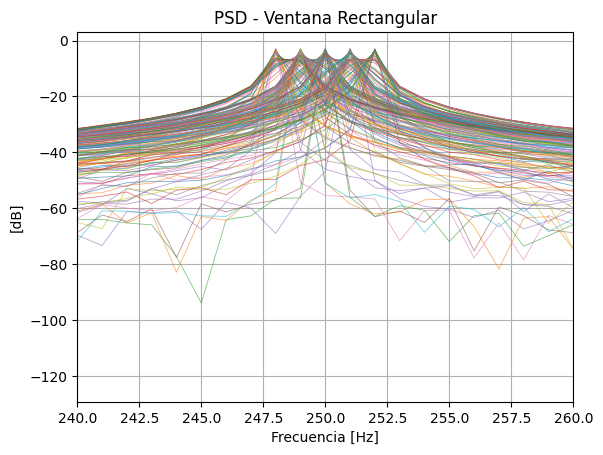

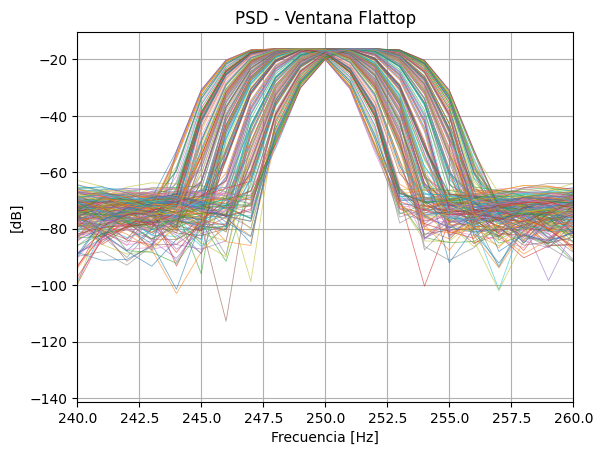

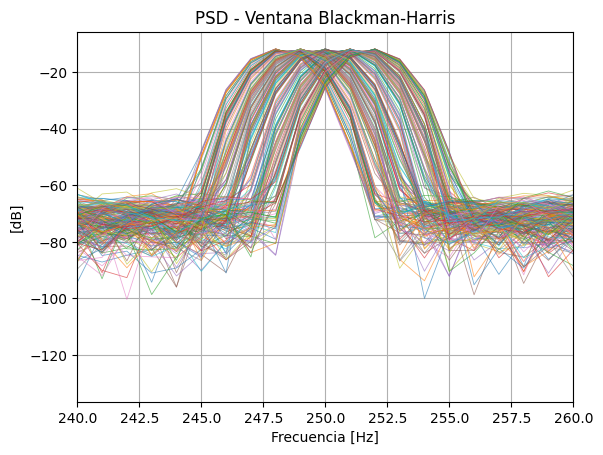

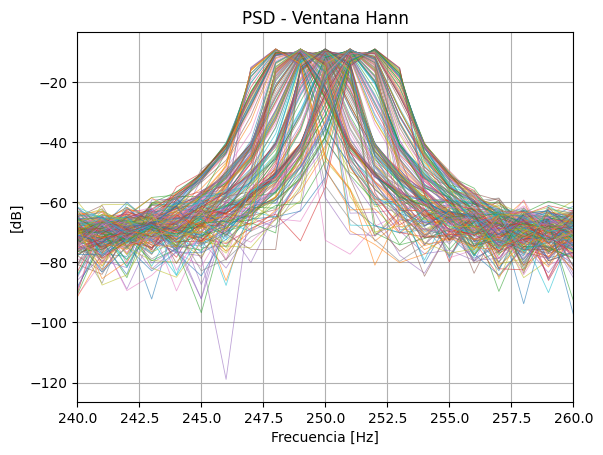

In [23]:
# --------------------------- Ploteos de FFT en PSD --------------------------- #


plt.figure (1)
# plt.plot (ff_zp, 10*np.log10(np.abs(X1_rect_zp)**2), linewidth=0.6, alpha=0.6) # para observar con zero-padding
plt.plot (ff, 10*np.log10(np.abs(X1_rect)**2), linewidth=0.6, alpha=0.6)
plt.title ('PSD - Ventana Rectangular')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
# plt.xlim (0, fs/2)
plt.xlim (240, 260)
plt.grid (True)

plt.figure (2)
# plt.plot (ff_zp, 10*np.log10(np.abs(X1_flat_zp)**2), linewidth=0.6, alpha=0.6) # para observar con zero-padding
plt.plot (ff, 10*np.log10(np.abs(X1_flat)**2), linewidth=0.6, alpha=0.6)
plt.title ('PSD - Ventana Flattop')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
# plt.xlim (0, fs/2)
plt.xlim (240, 260)
plt.grid (True)

plt.figure (3)
# plt.plot (ff_zp, 10*np.log10(np.abs(X1_bh_zp)**2), linewidth=0.6, alpha=0.6) # para observar con zero-padding
plt.plot (ff, 10*np.log10(np.abs(X1_bh)**2), linewidth=0.6, alpha=0.6)
plt.title ('PSD - Ventana Blackman-Harris')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
# plt.xlim (0, fs/2)
plt.xlim (240, 260)
plt.grid (True)

plt.figure (4)
# plt.plot (ff_zp, 10*np.log10(np.abs(X1_hann_zp)**2), linewidth=0.6, alpha=0.6) # para observar con zero-padding
plt.plot (ff, 10*np.log10(np.abs(X1_hann)**2), linewidth=0.6, alpha=0.6)
plt.title ('PSD - Ventana Hann')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
# plt.xlim (0, fs/2)
plt.xlim (240, 260)
plt.grid (True)

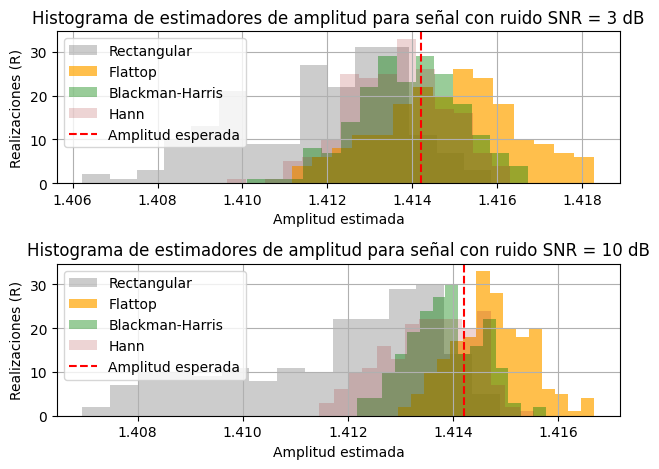

In [26]:
# --------------------------- Ploteos estimadores de amplitud --------------------------- #


plt.figure (5)

plt.subplot (2, 1, 1)
plt.hist (ax1_rect, bins=15, color='gray', alpha=0.4, label='Rectangular')
plt.hist (ax1_flat, bins=15, color='orange', alpha=0.7, label='Flattop')
plt.hist (ax1_bh, bins=15, color='green', alpha=0.4, label='Blackman-Harris')
plt.hist (ax1_hann, bins=15, color='brown', alpha=0.2, label='Hann')
plt.axvline (x=amp_0, linestyle='--', color='red', label='Amplitud esperada')
plt.title ('Histograma de estimadores de amplitud para señal con ruido SNR = 3 dB')
plt.ylabel ('Realizaciones (R)')
plt.xlabel ('Amplitud estimada')
plt.grid (True)
plt.legend ()

plt.subplot (2, 1, 2)
plt.hist (ax2_rect, bins=15, color='gray', alpha=0.4, label='Rectangular')
plt.hist (ax2_flat, bins=15, color='orange', alpha=0.7, label='Flattop')
plt.hist (ax2_bh, bins=15, color='green', alpha=0.4, label='Blackman-Harris')
plt.hist (ax2_hann, bins=15, color='brown', alpha=0.2, label='Hann')
plt.axvline (x=amp_0, linestyle='--', color='red', label='Amplitud esperada')
plt.title ('Histograma de estimadores de amplitud para señal con ruido SNR = 10 dB')
plt.ylabel ('Realizaciones (R)')
plt.xlabel ('Amplitud estimada')
plt.grid (True)
plt.legend ()

plt.tight_layout ()
plt.show ()

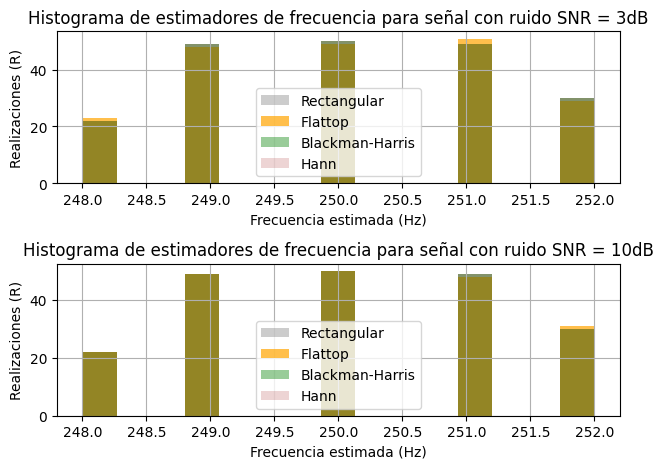

In [27]:
# --------------------------- Ploteos de estimadores de frecuencia --------------------------- #


plt.figure (6)

plt.subplot (2, 1, 1)
plt.hist (fx1_rect, bins=15, color='gray', alpha=0.4, label='Rectangular')
plt.hist (fx1_flat, bins=15, color='orange', alpha=0.7, label='Flattop')
plt.hist (fx1_bh, bins=15, color='green', alpha=0.4, label='Blackman-Harris')
plt.hist (fx1_hann, bins=15, color='brown', alpha=0.2, label='Hann')
plt.title ('Histograma de estimadores de frecuencia para señal con ruido SNR = 3dB')
plt.ylabel ('Realizaciones (R)')
plt.xlabel ('Frecuencia estimada (Hz)')
plt.legend ()
plt.grid (True)

plt.subplot (2, 1, 2)
plt.hist (fx2_rect, bins=15, color='gray', alpha=0.4, label='Rectangular')
plt.hist (fx2_flat, bins=15, color='orange', alpha=0.7, label='Flattop')
plt.hist (fx2_bh, bins=15, color='green', alpha=0.4, label='Blackman-Harris')
plt.hist (fx2_hann, bins=15, color='brown', alpha=0.2, label='Hann')
plt.title ('Histograma de estimadores de frecuencia para señal con ruido SNR = 10dB')
plt.ylabel ('Realizaciones (R)')
plt.xlabel ('Frecuencia estimada (Hz)')
plt.legend ()
plt.grid (True)

plt.tight_layout ()
plt.show ()

## Conclusiones
En síntesis, en base al trabajo realizado podemos destacar lo siguiente: confirmamos y visualizamos la relación de compromiso que genera el ventaneo en el análisis espectral discreto: la Flat-top fue la más fiel a la estimación de amplitud (mínimo sesgo de *scalloping* con corrección de ganancia coherente), la Blackman–Harris brindó la estimación de frecuencia más estable (menor varianza gracias al bajo desparramo espectral), la Hann ofreció un compromiso favorable entre fuga y resolución espectral, mientras que la rectangular maximizó la resolución aparente a costa de lóbulos laterales altos. Verificamos empíricamente Parseval, evidenciando conservación de energía pese a cambios en la forma del espectro. Observamos que incrementar el SNR de 3 a 10 dB reduce la varianza de ambos estimadores sin alterar el orden relativo entre ventanas. Comprobamos que el zero-padding no mejora la resolución física, pero interpola el espectro y facilita la localización de valores máximos. Operativamente, si el objetivo es dar con un estimador preciso para la amplitud, optamos por la ventana Flat-top; mientras que para un estimador de frecuencia con mínima varianza, la Blackman–Harris; y, de quere buscar un balance general con menor desparramo que la rectangular, utilizaríamos la ventana Hann.

## Autoevaluación del aprendizaje
- Interiorizamos la relación de compromiso según el uso de ventanas:
  - **Flat-top**: la más "fiel" en **amplitud** (mínimo sesgo por scalloping) al corregir por **ganancia coherente**.
  - **Blackman–Harris**: la más estable para **frecuencia** (menor varianza por baja fuga espectral).
  - **Hann**: compromiso robusto entre fuga y resolución.
  - **Rectangular**: máxima resolución aparente, pero **lóbulos laterales altos** → mayor desparramo si hay desintonía.
- Observamos el **impacto del SNR** (3 dB vs. 10 dB): al aumentar el SNR, disminuye la **varianza** de los estimadores, sin cambiar el ranking de ventanas (Flat-top en amplitud; Blackman–Harris en frecuencia).
- Practicamos la estimación de **sesgo y varianza** con **200 realizaciones**, interpretando histogramas y entendiendo cómo el ventaneo y el SNR moldean la dispersión de $\hat a$ y  $\hat f$.

En lo computacional, reforzamos el uso de **Jupyter Notebook, NumPy, SciPy y Matplotlib** para generar señales, aplicar ventanas, calcular DFT/PSD y producir gráficos comparativos. Incorporamos buenas prácticas de escalado (corrección por **ganancia coherente**) y detectamos mejoras futuras: calibrar SNR con $ P_{\text{sig}} = \mathrm{mean}(s^2) $, usar **interpolación de pico** para refinar $ \hat f $ sin aumentar $ N $, y tabular sistemáticamente sesgo/varianza por ventana y SNR.

En síntesis, integramos la teoría con simulaciones numéricas y visuales, y ahora podemos **elegir la ventana adecuada según el objetivo** (amplitud vs. frecuencia) y el **régimen de SNR**, entendiendo las consecuencias sobre sesgo, varianza y visualización espectral.